In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

# from qumcmc.classical_mcmc_routines import *
# from qumcmc.quantum_mcmc_routines_qulacs import *     #for Qulacs Simulator backend
# from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
from typing import Union
from qumcmc.trajectory_processing import *
import seaborn as sns

In [2]:
from qumcmc.restricted_samplng import MCMCState , RestrictedSampling

In [6]:
state = MCMCState('101001','1110', accepted= True)
rs1 = RestrictedSampling(model, temperature= 1./beta, initial_state= state)

In [9]:
rs1.mcmc_chain.get_accepted_dict()

Counter({'1010011110': 2,
         '0010011110': 1,
         '1110101110': 1,
         '1010101110': 3,
         '1010111110': 3,
         '0110111110': 18,
         '0010111110': 4,
         '1110111110': 4})

In [7]:
rs1.run_quantum_enhanced_mcmc(100 )

runnning quantum MCMC steps . ..: 100%|██████████| 100/100 [00:04<00:00, 22.12it/s]


MCMCChain()

            MODEL : my_model
Non-zero Interactions (J) : 45 / 45
Non-zero Bias (h) : 9 / 10
---------------------------------------------
Average Interaction Strength <|J|> :  0.5966799999999999
Average Bias Strength <|h|>:  0.5010000000000001
alpha :  0.5606804251097042
---------------------------------------------
Running Exact Sampling | beta :  1.100209


running over all possible configurations: 100%|██████████| 1024/1024 [00:00<00:00, 14287.17it/s]


saving distribution to model ...
Running Exact Sampling | beta :  1.100209


running over all possible configurations: 100%|██████████| 1024/1024 [00:00<00:00, 14553.34it/s]

saving distribution to model ...


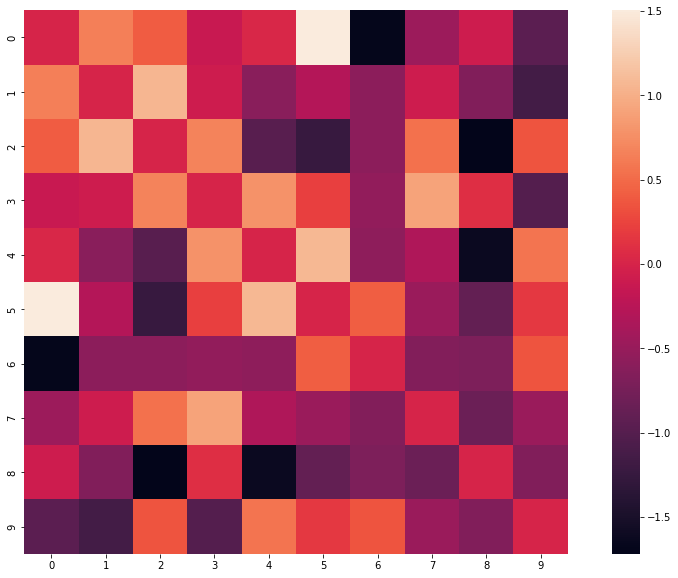

In [3]:
to_binary = lambda state_obtained, n_spins : f"{state_obtained:0{n_spins}b}"
# define the model
np.random.seed(610358)# should always be in the same cell!  
n_spins = 10

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.5 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')

model.model_summary()
## set current beta
beta = 1.100209

## run exact sampling over all possible configurations 
esm = Exact_Sampling(model, beta)
esm.run_exact_sampling(beta)

     MODEL : my_model |  beta : 1.100209
Num Most Probable States : 12
Entropy : 3.7838182697705967
---------------------------------------------


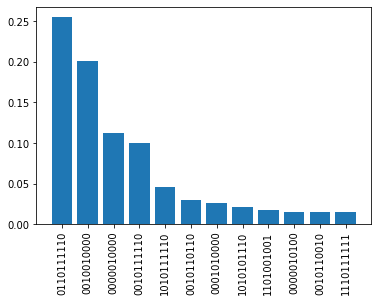

In [4]:
esm.sampling_summary()

#### Qulacs Exps

In [37]:
from qulacs import QuantumState

n = 2
state = QuantumState(n)
state.set_Haar_random_state(0)

# Get quantum bit numbers
qubit_count = state.get_qubit_count()
print("qubit_count", qubit_count)

# Get the probability that the specified qubit will be measured as 0
prob = state.get_zero_probability(1)
print("zero_prob_1", prob)


qubit_count 2
zero_prob_1 0.14831580678487433


In [38]:
np.absolute(state.get_amplitude(0)) , np.absolute( state.get_vector())

(0.2637259526321412, array([0.26372595, 0.28065001, 0.44726233, 0.80724259]))

In [39]:
1 - state.get_zero_probability(1)

0.8516841932151257

In [40]:

# Get arbitrary marginal probabilities
# Argument is an array of the same length as the number of qubits
# Specify 0,1,2. 0,1 is the probability of the subscript measured at that value
# 2 means that bit is peripheralized.
# For example, calculation of the probability that the third is measured as 0 and the 0th is measured as 1:
prob = state.get_marginal_probability([2,1])
print("marginal_prob", prob)


marginal_prob 0.8516841932151257


In [41]:

# Get the entropy of the probability distribution when measured on the Z basis
ent = state.get_entropy()
print("entropy", ent)

# Get squared norm (<a|a>)
# Because the operation maybe not Trace preserving, the norm of state does not necessarily to be 1.
sq_norm = state.get_squared_norm()
print("sqaured_norm", sq_norm)

# The number of measurements and sampling of all qubits Z-basis is given by the argument.
# Get a list of integers converted from the resulting binaries.
samples = state.sampling(10)
print("sampling", samples)

# Get a character string indicating whether the state vector is on CPU or GPU
dev_type = state.get_device_name()
print("device", dev_type)

entropy 0.9865530516551664
sqaured_norm 1.0
sampling [0, 2, 1, 2, 3, 3, 3, 3, 2, 3]
device cpu


In [177]:
[to_binary(s,2) for s in samples]

['11', '10', '10', '11', '10', '11', '10', '11', '10', '11']

In [183]:
f"{state.sampling(1)[0]:0{2}b}" 

'10'

#### Prepare new data objects

In [42]:
@dataclass
class MCMCState:
    
    var: str
    fixed: str
    
    accepted: bool = False
    
    def __post_init__(self):
        self.bitstring = self.var + self.fixed
        self.len_var = len(self.var)
        self.len_fixed = len(self.fixed)
        self.len = len(self.bitstring)
    
    def _update_var(self, new_state:str):
        if len(new_state) == self.len_var:
            self.var = new_state
            self.bitstring = self.var + self.fixed
        else : raise ValueError("Updated 'var' should be of len "+str(self.len_var))
    

#### Modify `run_qc_quantum_step`

In [43]:
d = MCMCState('10101', '110' , True)

#### Creating new class for Sampling

In [55]:
from typing import Union

@dataclass
class RestrictedSampling:
        
        model : IsingEnergyFunction
        # iterations : int = 10000
        temperature : float = 1.00
        initial_state : Optional[Union[ str, MCMCState]] = None
        
                
        def __post_init__(self):
                
                if self.initial_state is None : 
                        self.initial_state = MCMCState(get_random_state(model.num_spins), accepted=True)
                elif not isinstance(self.initial_state, MCMCState):
                        self.initial_state = MCMCState(self.initial_state, accepted=True)
                
                self.current_state: MCMCState = self.initial_state
                
                self.mcmc_chain: MCMCChain = MCMCChain([self.current_state])

                self.len_var = self.current_state.len_var; self.len_fixed = self.current_state.len_fixed 
        

        def run_classical_mcmc(self, iterations):
                
                energy_s = model.get_energy(self.current_state.bitstring)
                print('current state: ', self.current_state)
                for _ in tqdm(range(0, iterations), desc= 'running MCMC steps ...'):
                        # get sprime #
                        s_prime = MCMCState(get_random_state(self.current_state.len_var  ), self.current_state.fixed)
                        print('s_prime:', s_prime)
                        
                        # accept/reject s_prime
                        energy_sprime = model.get_energy(s_prime.bitstring)   # to make this scalable, I think you need to calculate energy ratios.
                        accepted = test_accept(
                        energy_s, energy_sprime, temperature=self.temperature
                        )
                        if accepted:
                                s_prime.accepted = accepted
                                self.current_state = s_prime
                                print('current state: ', self.current_state)
                                energy_s = model.get_energy(self.current_state.bitstring)
                        
                        self.mcmc_chain.add_state(s_prime)

                return self.mcmc_chain

        def _get_quantum_proposition():
                pass
        def run_quantum_enhanced_mcmc(self, iterations):

                energy_s = model.get_energy(self.current_state.bitstring)
                print('current state: ', self.current_state)
                qc_s = initialise_qc(n_spins= model.num_spins, bitstring= self.current_state.bitstring )
                for _ in tqdm(range(0, iterations), desc='runnning quantum MCMC steps . ..' ):
                        
                        # get sprime #
                        qc_s = initialise_qc(n_spins= model.num_spins, bitstring=self.current_state.bitstring)
                        s_prime = run_qc_quantum_step(
                        qc_initialised_to_s=qc_s, model=model
                        )
                        s_prime = MCMCState(s_prime[:self.len_var], s_prime[self.len_var:])
                        print('s_prime:', s_prime)

                        # accept/reject s_prime
                        energy_sprime = model.get_energy(s_prime.bitstring)
                        accepted = test_accept(
                        energy_s, energy_sprime, temperature=self.temperature
                        )
                        if accepted:
                                s_prime.accepted = accepted
                                self.current_state = s_prime
                                print('current state: ', self.current_state)
                                energy_s = model.get_energy(self.current_state.bitstring)
                        
                        self.mcmc_chain.add_state(s_prime)
                                

                return self.mcmc_chain 
                



In [56]:
def run_qc_quantum_step(
    qc_initialised_to_s: QuantumCircuit, model: IsingEnergyFunction, check_fixed: bool = True, max_checks: int = 100
) -> str:

    """
    Takes in a qc initialized to some state "s". After performing unitary evolution U=exp(-iHt)
    , circuit is measured once. Function returns the bitstring s', the measured state .

    ARGS:
    ----
    qc_initialised_to_s:
    model:
    
    """

    h = model.get_h
    J = model.get_J

    # init_qc=initialise_qc(model.num_spins=model.num_spins, bitstring='1'*model.num_spins)
    gamma = np.round(np.random.uniform(0.25, 0.6), decimals=2)
    time = np.random.choice(list(range(2, 12)))  # earlier I had [2,20]
    delta_time = 0.8 
    num_trotter_steps = int(np.floor((time / delta_time)))
    qc_evol_h1 = fn_qc_h1(model.num_spins, gamma, model.alpha, h, delta_time)
    qc_evol_h2 = fn_qc_h2(J, model.alpha, gamma, delta_time=delta_time)
    trotter_ckt = trottered_qc_for_transition(
        model.num_spins, qc_evol_h1, qc_evol_h2, num_trotter_steps=num_trotter_steps
    )
    qc_for_mcmc = combine_2_qc(qc_initialised_to_s, trotter_ckt)# i can get rid of this!
    # run the circuit ##
    q_state=QuantumState(qubit_count=model.num_spins)
    q_state.set_zero_state()
    qc_for_mcmc.update_quantum_state(q_state)

    if check_fixed :
        ## repeats sampling untill right fixed state is found ##
        right_sample = False; checks= 0
        while not right_sample and checks < max_checks:
            state_obtained= q_state.sampling(sampling_count= 1)[0] ; checks+= 1
            if check_fixed_state( f"{state_obtained:0{model.num_spins}b}" ) : right_sample = True
            
    else :
        state_obtained= q_state.sampling(sampling_count= 1)[0]

    # state_obtained= [f"{state:0{model.num_spins}b}" for state in state_obtained]
    return f"{state_obtained:0{model.num_spins}b}"


In [57]:
state = MCMCState('101001','1110', accepted= True)

In [58]:
qc_s = initialise_qc(n_spins= model.num_spins, bitstring= state.bitstring)

In [59]:
check_fixed_state = lambda bitstr : bitstr[ -state.len_fixed: ] == state.fixed

In [60]:
rs1 = RestrictedSampling(model, temperature= 1./beta, initial_state= state)

In [61]:
smp = rs1.run_quantum_enhanced_mcmc(iterations= 100)

current state:  MCMCState(var='101001', fixed='1110', accepted=True)


runnning quantum MCMC steps . ..:   9%|▉         | 9/100 [00:00<00:01, 82.70it/s]

s_prime: MCMCState(var='111011', fixed='1110', accepted=False)
current state:  MCMCState(var='111011', fixed='1110', accepted=True)
s_prime: MCMCState(var='111010', fixed='1110', accepted=False)
s_prime: MCMCState(var='110010', fixed='1110', accepted=False)
s_prime: MCMCState(var='111111', fixed='1110', accepted=False)
s_prime: MCMCState(var='111010', fixed='1110', accepted=False)
current state:  MCMCState(var='111010', fixed='1110', accepted=True)
s_prime: MCMCState(var='110011', fixed='1110', accepted=False)
s_prime: MCMCState(var='001010', fixed='1110', accepted=False)
s_prime: MCMCState(var='101010', fixed='1110', accepted=False)
current state:  MCMCState(var='101010', fixed='1110', accepted=True)
s_prime: MCMCState(var='101011', fixed='1110', accepted=False)
current state:  MCMCState(var='101011', fixed='1110', accepted=True)
s_prime: MCMCState(var='101001', fixed='1110', accepted=False)
s_prime: MCMCState(var='101001', fixed='1110', accepted=False)
s_prime: MCMCState(var='001111'

runnning quantum MCMC steps . ..:  26%|██▌       | 26/100 [00:00<00:01, 67.81it/s]

s_prime: MCMCState(var='011011', fixed='1110', accepted=False)
current state:  MCMCState(var='011011', fixed='1110', accepted=True)
s_prime: MCMCState(var='011110', fixed='1110', accepted=False)
s_prime: MCMCState(var='011011', fixed='1110', accepted=False)
current state:  MCMCState(var='011011', fixed='1110', accepted=True)
s_prime: MCMCState(var='011011', fixed='1110', accepted=False)
current state:  MCMCState(var='011011', fixed='1110', accepted=True)
s_prime: MCMCState(var='001011', fixed='1110', accepted=False)
s_prime: MCMCState(var='111010', fixed='1110', accepted=False)
s_prime: MCMCState(var='111011', fixed='1110', accepted=False)
s_prime: MCMCState(var='101010', fixed='1110', accepted=False)
s_prime: MCMCState(var='101010', fixed='1110', accepted=False)
s_prime: MCMCState(var='111011', fixed='1110', accepted=False)
s_prime: MCMCState(var='011111', fixed='1110', accepted=False)
s_prime: MCMCState(var='001111', fixed='1110', accepted=False)
s_prime: MCMCState(var='100101', fixe

runnning quantum MCMC steps . ..:  34%|███▍      | 34/100 [00:00<00:00, 67.18it/s]

s_prime: MCMCState(var='110010', fixed='1110', accepted=False)
s_prime: MCMCState(var='100010', fixed='1110', accepted=False)
s_prime: MCMCState(var='111011', fixed='1110', accepted=False)
s_prime: MCMCState(var='011011', fixed='1110', accepted=False)
current state:  MCMCState(var='011011', fixed='1110', accepted=True)
s_prime: MCMCState(var='111111', fixed='1110', accepted=False)
s_prime: MCMCState(var='011011', fixed='1110', accepted=False)
current state:  MCMCState(var='011011', fixed='1110', accepted=True)
s_prime: MCMCState(var='011010', fixed='1110', accepted=False)
s_prime: MCMCState(var='001011', fixed='1110', accepted=False)
s_prime: MCMCState(var='101011', fixed='1110', accepted=False)


runnning quantum MCMC steps . ..:  41%|████      | 41/100 [00:00<00:00, 61.92it/s]

s_prime: MCMCState(var='010010', fixed='1110', accepted=False)
s_prime: MCMCState(var='101010', fixed='1110', accepted=False)
s_prime: 

runnning quantum MCMC steps . ..:  48%|████▊     | 48/100 [00:00<00:00, 59.49it/s]

MCMCState(var='110111', fixed='1110', accepted=False)
s_prime: MCMCState(var='011011', fixed='1110', accepted=False)
current state:  MCMCState(var='011011', fixed='1110', accepted=True)
s_prime: MCMCState(var='101010', fixed='1110', accepted=False)
s_prime: MCMCState(var='011011', fixed='1110', accepted=False)
current state:  MCMCState(var='011011', fixed='1110', accepted=True)
s_prime: MCMCState(var='011011', fixed='1110', accepted=False)
current state:  MCMCState(var='011011', fixed='1110', accepted=True)
s_prime: MCMCState(var='001010', fixed='1110', accepted=False)
s_prime: MCMCState(var='110010', fixed='1110', accepted=False)
s_prime: MCMCState(var='001011', fixed='1110', accepted=False)
s_prime: MCMCState(var='001011', fixed='1110', accepted=False)
current state:  MCMCState(var='001011', fixed='1110', accepted=True)
s_prime: MCMCState(var='001011', fixed='1110', accepted=False)
current state:  MCMCState(var='001011', fixed='1110', accepted=True)
s_prime: MCMCState(var='011011', f

runnning quantum MCMC steps . ..:  64%|██████▍   | 64/100 [00:00<00:00, 66.67it/s]

s_prime: MCMCState(var='101011', fixed='1110', accepted=False)
current state:  MCMCState(var='101011', fixed='1110', accepted=True)
s_prime: MCMCState(var='111011', fixed='1110', accepted=False)
s_prime: MCMCState(var='111011', fixed='1110', accepted=False)
s_prime: MCMCState(var='001011', fixed='1110', accepted=False)
current state:  MCMCState(var='001011', fixed='1110', accepted=True)
s_prime: MCMCState(var='111011', fixed='1110', accepted=False)
s_prime: MCMCState(var='011011', fixed='1110', accepted=False)
current state:  MCMCState(var='011011', fixed='1110', accepted=True)
s_prime: MCMCState(var='101011', fixed='1110', accepted=False)
s_prime: MCMCState(var='001011', fixed='1110', accepted=False)
s_prime: MCMCState(var='011011', fixed='1110', accepted=False)
current state:  MCMCState(var='011011', fixed='1110', accepted=True)
s_prime: MCMCState(var='101011', fixed='1110', accepted=False)
current state:  MCMCState(var='101011', fixed='1110', accepted=True)
s_prime: MCMCState(var='1

runnning quantum MCMC steps . ..:  71%|███████   | 71/100 [00:01<00:00, 63.96it/s]

s_prime: MCMCState(var='001011', fixed='1110', accepted=False)
current state:  MCMCState(var='001011', fixed='1110', accepted=True)
s_prime: MCMCState(var='000001', fixed='1110', accepted=False)
s_prime: MCMCState(var='011001', fixed='1110', accepted=False)
s_prime: MCMCState(var='011001', fixed='1110', accepted=False)
s_prime: MCMCState(var='011010', fixed='1110', accepted=False)
s_prime: MCMCState(var='001010', fixed='1110', accepted=False)
s_prime: MCMCState(var='111110', fixed='1110', accepted=False)


runnning quantum MCMC steps . ..:  78%|███████▊  | 78/100 [00:01<00:00, 54.05it/s]

s_prime: MCMCState(var='001011', fixed='1110', accepted=False)
current state:  MCMCState(var='001011', fixed='1110', accepted=True)
s_prime: MCMCState(var='100010', fixed='1110', accepted=False)


runnning quantum MCMC steps . ..:  85%|████████▌ | 85/100 [00:01<00:00, 57.35it/s]

s_prime: MCMCState(var='101010', fixed='1110', accepted=False)
s_prime: MCMCState(var='101101', fixed='1110', accepted=False)
s_prime: MCMCState(var='100011', fixed='1110', accepted=False)
s_prime: MCMCState(var='001011', fixed='1110', accepted=False)
current state:  MCMCState(var='001011', fixed='1110', accepted=True)
s_prime: MCMCState(var='101010', fixed='1110', accepted=False)
s_prime: MCMCState(var='101010', fixed='1110', accepted=False)
s_prime: MCMCState(var='101011', fixed='1110', accepted=False)
s_prime: MCMCState(var='111111', fixed='1110', accepted=False)
s_prime: MCMCState(var='011011', fixed='1110', accepted=False)
current state:  MCMCState(var='011011', fixed='1110', accepted=True)
s_prime: MCMCState(var='011111', fixed='1110', accepted=False)
s_prime: MCMCState(var='110010', fixed='1110', accepted=False)
s_prime: MCMCState(var='001011', fixed='1110', accepted=False)
s_prime: MCMCState(var='011011', fixed='1110', accepted=False)
current state:  MCMCState(var='011011', fix

runnning quantum MCMC steps . ..:  93%|█████████▎| 93/100 [00:01<00:00, 61.17it/s]

s_prime: MCMCState(var='101010', fixed='1110', accepted=False)
s_prime: MCMCState(var='011111', fixed='1110', accepted=False)


runnning quantum MCMC steps . ..: 100%|██████████| 100/100 [00:01<00:00, 62.72it/s]

s_prime: MCMCState(var='011011', fixed='1110', accepted=False)
current state:  MCMCState(var='011011', fixed='1110', accepted=True)
s_prime: MCMCState(var='101010', fixed='1110', accepted=False)
s_prime: MCMCState(var='011011', fixed='1110', accepted=False)
current state:  MCMCState(var='011011', fixed='1110', accepted=True)
s_prime: MCMCState(var='111011', fixed='1110', accepted=False)
s_prime: MCMCState(var='111010', fixed='1110', accepted=False)
s_prime: MCMCState(var='101111', fixed='1110', accepted=False)


In [62]:
smp = rs1.run_classical_mcmc(iterations=100)

current state:  MCMCState(var='011011', fixed='1110', accepted=True)


running MCMC steps ...: 100%|██████████| 100/100 [00:00<00:00, 8494.45it/s]

s_prime: MCMCState(var='000011', fixed='1110', accepted=False)
s_prime: MCMCState(var='000011', fixed='1110', accepted=False)
s_prime: MCMCState(var='001010', fixed='1110', accepted=False)
s_prime: MCMCState(var='111000', fixed='1110', accepted=False)
s_prime: MCMCState(var='001100', fixed='1110', accepted=False)
s_prime: MCMCState(var='110011', fixed='1110', accepted=False)
s_prime: MCMCState(var='111110', fixed='1110', accepted=False)
s_prime: MCMCState(var='010001', fixed='1110', accepted=False)
s_prime: MCMCState(var='001101', fixed='1110', accepted=False)
s_prime: MCMCState(var='010101', fixed='1110', accepted=False)
s_prime: MCMCState(var='001010', fixed='1110', accepted=False)
s_prime: MCMCState(var='110010', fixed='1110', accepted=False)
s_prime: MCMCState(var='111100', fixed='1110', accepted=False)
s_prime: MCMCState(var='111011', fixed='1110', accepted=False)
s_prime: MCMCState(var='000111', fixed='1110', accepted=False)
s_prime: MCMCState(var='110010', fixed='1110', accepted